# Intro
The goal of this notebook is to organize the story for the XHOCl and XHOD theory investigations. I went down a series of rabbit holes and that left my notebook very scattered. This notebook should show what the final story is, with explanations for why things are done certain ways. 

# Imports

In [1]:
import sys
import os
sys.path.append('../CGH_Toolbox/')
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from matplotlib.colors import LogNorm
import numpy as np
import nglview as nv
import MDAnalysis as mda
import pyvibdmc as pv
import utilities as uts
import gaussian_tools as gt
import glob
import pandas as pd
import pickle
from scipy import interpolate
import dvr, utilities, dvr_arrays
from McUtils import Data as McData

# Load Data

In [2]:
def pull_charges(file, rearrange=False):
    split = []
    with open(file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            split.append(line.split())
        
    d = {}

    for line in split:
        #print(line)
        if len(line) < 2:
            continue
        if line[1] in ['O', 'Br', 'Cl', 'I', 'H']:
            head = line[0].split('_')
            for h in head:
                if h.isdigit():
                    key = h + "-" + line[1]
            #key = line[0].split('_')[1] + "-" + line[1]
            #print(key)
            if key in d:
                key = key + "_1"
            d[key] = line[3]

    n_d = {}
    for key in d:
        s = key.split('-')
        if s[0] in n_d:
            n_d[s[0]].append(d[key])
        else:
            n_d[s[0]] = [d[key]]
    for key in n_d:
        n_d[key] = np.array(n_d[key])
    #print(n_d)
    l = []
    keys = list(n_d.keys())
    if rearrange:
        keys.insert(1, keys.pop(-1)) 
    for k in keys:
        l.append(n_d[k])
    return np.asarray(l, dtype=float)
        
    
        

In [3]:
clhocl_oop_nbo = pull_charges('oop_s_rOH_opt/clhocl/natural_charges.txt', rearrange=True)
ihocl_oop_nbo = pull_charges('oop_s_rOH_opt/ihocl/natural_charges.txt', rearrange=True)
brhocl_oop_nbo = pull_charges('oop_s_rOH_opt/brhocl/natural_charges.txt', rearrange=True)
brhocl_pp_oop_nbo = pull_charges('oop_s_rOH_opt/brhocl_pp/natural_charges.txt', rearrange=True)
clhod_oop_nbo = pull_charges('oop_s_rOH_opt/clhod/natural_charges.txt')
brhod_oop_nbo = pull_charges('oop_s_rOH_opt/brhod/natural_charges.txt')
brhod_pp_oop_nbo = pull_charges('oop_s_rOH_opt/brhod_pp/natural_charges.txt')
ihod_oop_nbo = pull_charges('oop_s_rOH_opt/ihod/natural_charges.txt')

In [4]:
clhocl_rOH_nbo = pull_charges('rOH_s_oop_0/clhocl/natural_charges.txt')
clhod_rOH_nbo = pull_charges('rOH_s_oop_0/clhod/natural_charges.txt')
brhocl_rOH_nbo = pull_charges('rOH_s_oop_0/brhocl/natural_charges.txt')
brhocl_pp_rOH_nbo = pull_charges('rOH_s_oop_0/brhocl_pp/natural_charges.txt')
brhod_rOH_nbo = pull_charges('rOH_s_oop_0/brhod/natural_charges.txt')
brhod_pp_rOH_nbo = pull_charges('rOH_s_oop_0/brhod_pp/natural_charges.txt')
ihocl_rOH_nbo = pull_charges('rOH_s_oop_0/ihocl/natural_charges.txt')
ihod_rOH_nbo = pull_charges('rOH_s_oop_0/ihod/natural_charges.txt')

# Explanations

## What is NBO?

## LOT/Basis sets

### ECP vs tz

not really sure how to show this

## Addressing discontinuities in the NBO analysis results

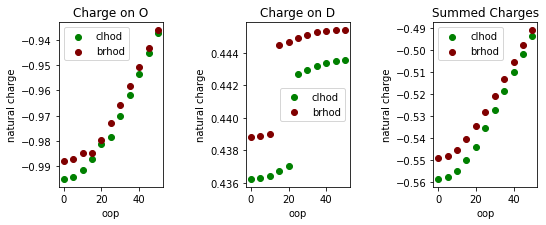

In [27]:
fig, axs = plt.subplots(1, 3, sharex=True)
oop = np.arange(0,55,5)
axs[0].scatter(oop, clhod_oop_nbo[:,0], label="clhod", color='green')
axs[0].scatter(oop, brhod_oop_nbo[:,0], label="brhod", color='maroon')
axs[1].scatter(oop,clhod_oop_nbo[:,1], label="clhod", color='green')
axs[1].scatter(oop,brhod_oop_nbo[:,1], label="brhod", color='maroon')
axs[2].scatter(oop, clhod_oop_nbo[:,0] + clhod_oop_nbo[:,1], label="clhod", color='green')
axs[2].scatter(oop, brhod_oop_nbo[:,0] + brhod_oop_nbo[:,1], label="brhod", color='maroon')
for a in axs:
    a.legend(loc='best')
    a.set_xlabel('oop')
    a.set_ylabel('natural charge')
axs[0].set_title('Charge on O')
axs[1].set_title('Charge on D')
axs[2].set_title('Summed Charges')
plt.tight_layout()
fig.set_size_inches(w=8,h=3)
plt.savefig('why_are_we_using_summed_OD.pdf')

Try visualizing the orbitals

# OOP scan, optimized rOH

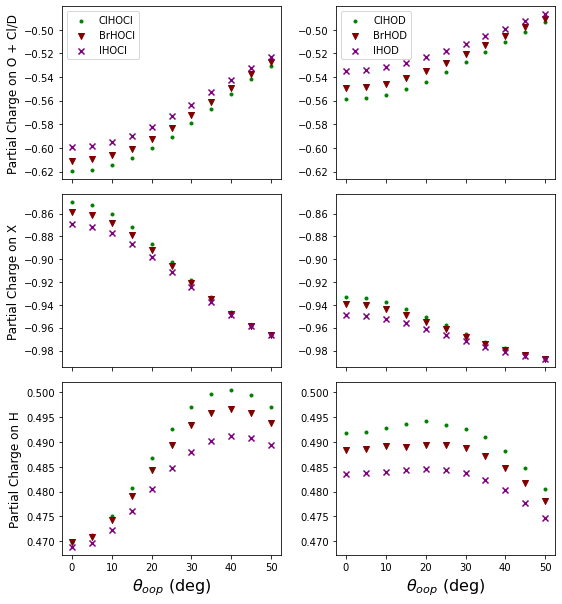

In [13]:
%matplotlib inline
fig, axs = plt.subplots(3, 2, sharex=True)


oop = np.arange(0,55,5)
axs[0,0].scatter(oop, clhocl_oop_nbo[:,0] + clhocl_oop_nbo[:,2], label="ClHOCl", color='green', marker='.')
axs[1,0].scatter(oop, clhocl_oop_nbo[:,1], label="ClHOCl", color='green', marker='.')
axs[2,0].scatter(oop, clhocl_oop_nbo[:,3], label="ClHOCl", color='green', marker='.')

axs[0,0].scatter(oop, brhocl_oop_nbo[:,0]+ brhocl_oop_nbo[:,2], label="BrHOCl", color='maroon', marker='v')
axs[1,0].scatter(oop, brhocl_oop_nbo[:,1], label="BrHOCl", color='maroon', marker='v')
axs[2,0].scatter(oop, brhocl_oop_nbo[:,3], label="BrHOCl", color='maroon', marker='v')

axs[0,0].scatter(oop, ihocl_oop_nbo[:,0] + ihocl_oop_nbo[:,2], label="IHOCl", color='purple', marker='x')
axs[1,0].scatter(oop, ihocl_oop_nbo[:,1], label="IHOCl", color='purple', marker='x')
axs[2,0].scatter(oop, ihocl_oop_nbo[:,3], label="IHOCl", color='purple', marker='x')
    
axs[0,1].scatter(oop, clhod_oop_nbo[:,0] + clhod_oop_nbo[:,1], label="ClHOD", color='green', marker='.')
axs[1,1].scatter(oop, clhod_oop_nbo[:,2], label="ClHOD", color='green', marker='.')
axs[2,1].scatter(oop, clhod_oop_nbo[:,3], label="ClHOD", color='green', marker='.')
axs[0,1].scatter(oop, brhod_oop_nbo[:,0] + brhod_oop_nbo[:,1], label="BrHOD", color='maroon', marker='v')
axs[1,1].scatter(oop, brhod_oop_nbo[:,2], label="BrHOD", color='maroon', marker='v')
axs[2,1].scatter(oop, brhod_oop_nbo[:,3], label="BrHOD", color='maroon', marker='v')
axs[0,1].scatter(oop, ihod_oop_nbo[:,0] + ihod_oop_nbo[:,1], label="IHOD", color='purple', marker='x')
axs[1,1].scatter(oop, ihod_oop_nbo[:,2], label="IHOD", color='purple', marker='x')
axs[2,1].scatter(oop, ihod_oop_nbo[:,3], label="IHOD", color='purple', marker='x')

axs[0,0].legend(loc='best')
axs[0,1].legend(loc='best')
        
#axs[0,0].set_title("XHOCl")
#axs[0,1].set_title("XHOD")
axs[0,0].set_ylabel("Partial Charge on O + Cl/D", fontsize=12)
axs[1,0].set_ylabel("Partial Charge on X", fontsize=12)
axs[2,0].set_ylabel("Partial Charge on H", fontsize=12)

axs[2,0].set_xlabel(r'$\theta_{oop}$ (deg)', fontsize=16)
axs[2,1].set_xlabel(r'$\theta_{oop}$ (deg)', fontsize=16)

axs[0,0].sharey(axs[0,1])
axs[1,0].sharey(axs[1,1])
axs[2,0].sharey(axs[2,1])

fig.subplots_adjust(wspace = 0, hspace = 0)
fig.set_size_inches(w=8,h=8.5)
        
plt.tight_layout()

plt.savefig('natural_charges_oop.pdf')


# OOP scan, rigid rOH

    - start with HOCl by itself, optimize, then add in x and optimize rOH (rOX?) with fixed HOCl parameters
    - then run a scan changing oop with the optimized rOH

# rOH scan, fixed planar

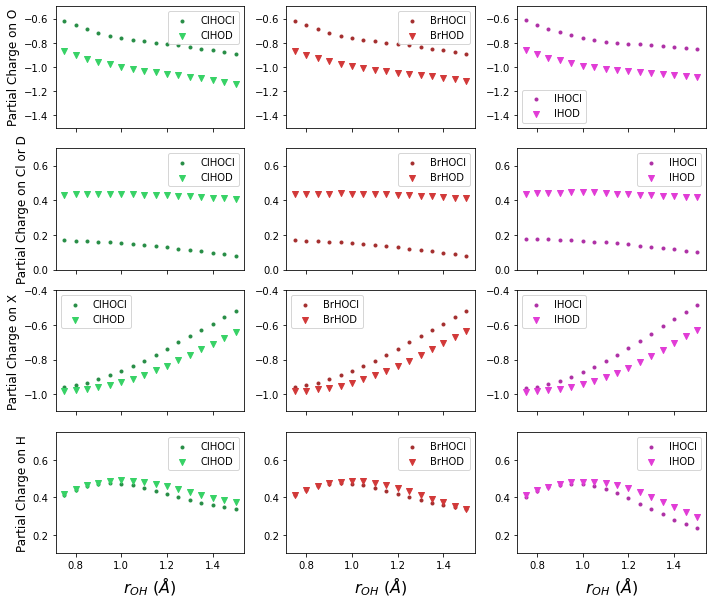

In [8]:
%matplotlib inline
fig, axs = plt.subplots(4, 3, sharex=True)

oop = np.arange(0.75,1.55,0.05)
for i in range(4):axs[i,0].scatter(oop, clhocl_rOH_nbo[:,i], label="ClHOCl", color='#268D45', marker='.')
for i in range(4):axs[i,0].scatter(oop, clhod_rOH_nbo[:,i], label="ClHOD", color='#37D266', marker='v')
for i in range(4):axs[i,1].scatter(oop, brhocl_rOH_nbo[:,i], label="BrHOCl", color='#A42D2D', marker='.')
#for i in range(4):axs[i,1].scatter(oop, brhocl_pp_rOH_nbo[:,i],label="BrHOCl_pp", color='black', marker='.')
for i in range(4):axs[i,1].scatter(oop, brhod_rOH_nbo[:,i], label="BrHOD", color='#D23939', marker='v')
#for i in range(4):axs[i,1].scatter(oop, brhod_pp_rOH_nbo[:,i], label="BrHOD_pp", color='black', marker='v')
for i in range(4):axs[i,2].scatter(oop, ihocl_rOH_nbo[:,i], label="IHOCl", color='#AE2FA5', marker='.')
for i in range(4):axs[i,2].scatter(oop, ihod_rOH_nbo[:,i], label="IHOD", color='#E13CD6', marker='v')

for ax in axs[0,:]:ax.set_ylim(-1.5, -0.5)  
for ax in axs[1,:]:ax.set_ylim(0, 0.7)
for ax in axs[2,:]:ax.set_ylim(-1.1, -0.4)
for ax in axs[3,:]:ax.set_ylim(0.1, 0.75)
for a in axs:
    for b in a:
        b.legend(loc='best')
        
axs[0,0].set_ylabel("Partial Charge on O", fontsize=12)
axs[1,0].set_ylabel("Partial Charge on Cl or D", fontsize=12)
axs[2,0].set_ylabel("Partial Charge on X", fontsize=12)
axs[3,0].set_ylabel("Partial Charge on H", fontsize=12)

axs[3,0].set_xlabel(r'$r_{OH}$ ($\AA$)', fontsize=16)
axs[3,1].set_xlabel(r'$r_{OH}$ ($\AA$)', fontsize=16)
axs[3,2].set_xlabel(r'$r_{OH}$ ($\AA$)', fontsize=16)


fig.subplots_adjust(wspace = 0, hspace = 0)
fig.set_size_inches(w=10,h=8.5)
plt.tight_layout()
plt.savefig('natural_charges_xhocl_v_xhod.pdf')

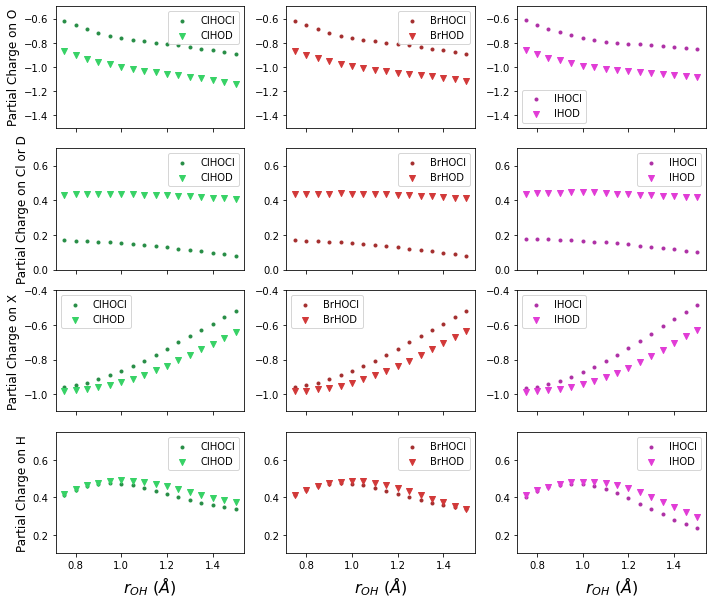

In [8]:
%matplotlib inline
fig, axs = plt.subplots(4, 3, sharex=True)

rOH = np.arange(0.75,1.55,0.05)
axs[0,0].scatter(rOH, clhocl_rOH_nbo[:,0], label="ClHOCl", color='#268D45', marker='.')
axs[1,0].scatter(rOH, clhocl_rOH_nbo[:,0], label="ClHOCl", color='#268D45', marker='.')
axs[2,0].scatter(rOH, clhocl_rOH_nbo[:,0], label="ClHOCl", color='#268D45', marker='.')

for i in range(4):axs[i,0].scatter(rOH, clhod_rOH_nbo[:,i], label="ClHOD", color='#37D266', marker='v')
for i in range(4):axs[i,1].scatter(rOH, brhocl_rOH_nbo[:,i], label="BrHOCl", color='#A42D2D', marker='.')
for i in range(4):axs[i,1].scatter(rOH, brhod_rOH_nbo[:,i], label="BrHOD", color='#D23939', marker='v')
for i in range(4):axs[i,2].scatter(rOH, ihocl_rOH_nbo[:,i], label="IHOCl", color='#AE2FA5', marker='.')
for i in range(4):axs[i,2].scatter(rOH, ihod_rOH_nbo[:,i], label="IHOD", color='#E13CD6', marker='v')

"""for ax in axs[0,:]:ax.set_ylim(-1.5, -0.5)  
for ax in axs[1,:]:ax.set_ylim(0, 0.7)
for ax in axs[2,:]:ax.set_ylim(-1.1, -0.4)
for ax in axs[3,:]:ax.set_ylim(0.1, 0.75)"""
for a in axs:
    for b in a:
        b.legend(loc='best')
        
axs[0,0].set_ylabel("Partial Charge on O", fontsize=12)
axs[1,0].set_ylabel("Partial Charge on Cl or D", fontsize=12)
axs[2,0].set_ylabel("Partial Charge on X", fontsize=12)
axs[3,0].set_ylabel("Partial Charge on H", fontsize=12)

axs[3,0].set_xlabel(r'$r_{OH}$ ($\AA$)', fontsize=16)
axs[3,1].set_xlabel(r'$r_{OH}$ ($\AA$)', fontsize=16)
axs[3,2].set_xlabel(r'$r_{OH}$ ($\AA$)', fontsize=16)


fig.subplots_adjust(wspace = 0, hspace = 0)
fig.set_size_inches(w=10,h=8.5)
plt.tight_layout()
plt.savefig('natural_charges_xhocl_v_xhod.pdf')

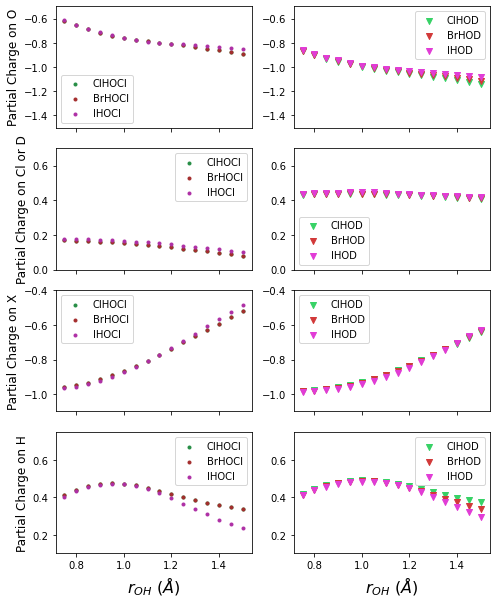

In [9]:
%matplotlib inline
fig, axs = plt.subplots(4, 2, sharex=True)

oop = np.arange(0.75,1.55,0.05)
for i in range(4): axs[i,0].scatter(oop, clhocl_rOH_nbo[:,i], label="ClHOCl", color='#268D45', marker='.')
for i in range(4): axs[i,1].scatter(oop, clhod_rOH_nbo[:,i], label="ClHOD", color='#37D266', marker='v')
for i in range(4): axs[i,0].scatter(oop, brhocl_rOH_nbo[:,i], label="BrHOCl", color='#A42D2D', marker='.')
#for i in range(4): axs[i,0].scatter(oop, brhocl_pp_rOH_nbo[:,i], label="BrHOCl_pp", color='black', marker='.')
for i in range(4): axs[i,1].scatter(oop, brhod_rOH_nbo[:,i], label="BrHOD", color='#D23939', marker='v')
#for i in range(4): axs[i,1].scatter(oop, brhod_pp_rOH_nbo[:,i], label="BrHOD_pp", color='black', marker='v')
for i in range(4): axs[i,0].scatter(oop, ihocl_rOH_nbo[:,i], label="IHOCl", color='#AE2FA5', marker='.')
for i in range(4): axs[i,1].scatter(oop, ihod_rOH_nbo[:,i], label="IHOD", color='#E13CD6', marker='v')

for ax in axs[0,:]:ax.set_ylim(-1.5, -0.5) 
for ax in axs[1,:]:ax.set_ylim(0, 0.7)
for ax in axs[2,:]:ax.set_ylim(-1.1, -0.4)
for ax in axs[3,:]:ax.set_ylim(0.1, 0.75)
for a in axs:
    for b in a:
        b.legend(loc='best')
        
axs[0,0].set_ylabel("Partial Charge on O", fontsize=12)
axs[1,0].set_ylabel("Partial Charge on Cl or D", fontsize=12)
axs[2,0].set_ylabel("Partial Charge on X", fontsize=12)
axs[3,0].set_ylabel("Partial Charge on H", fontsize=12)
axs[3,0].set_xlabel(r'$r_{OH}$ ($\AA$)', fontsize=16)
axs[3,1].set_xlabel(r'$r_{OH}$ ($\AA$)', fontsize=16)

fig.subplots_adjust(wspace = 0, hspace = 0)
fig.set_size_inches(w=7,h=8.5)
plt.tight_layout()
plt.savefig('natural_charges_xhocl_v_xhod_version2.pdf')


# DVR of oop bend

In [5]:
clhocl_oop_s = gt.GLogInterpreter("oop_s_rOH_opt/clhocl/clhocl_oop_s.log")

In [6]:
clhocl_oop_s.Energy

array([-995.15246, -995.15353, -995.15462, -995.15573, -995.15686,
       -995.15801, -995.15918, -995.16038, -995.16159, -995.16283,
       -995.16408, -995.16536, -995.16665, -995.16796, -995.16929,
       -995.17063, -995.17197, -995.17333, -995.17468, -995.17603,
       -995.17738, -995.17871, -995.18002, -995.1813 , -995.18255,
       -995.18375, -995.18491, -995.18601, -995.18704, -995.188  ,
       -995.18887, -995.18965, -995.19034, -995.19092, -995.19139,
       -995.19175, -995.19199, -995.19211, -995.19211, -995.19199,
       -995.19175, -995.19139, -995.19092, -995.19034, -995.18965,
       -995.18887, -995.188  , -995.18704, -995.18601, -995.18491,
       -995.18375, -995.18255, -995.1813 , -995.18002, -995.17871,
       -995.17738, -995.17603, -995.17468, -995.17333, -995.17197,
       -995.17063, -995.16929, -995.16796, -995.16665, -995.16536,
       -995.16408, -995.16283, -995.16159, -995.16038, -995.15918,
       -995.15801, -995.15686, -995.15573, -995.15462, -995.15

In [ ]:
grid = dvr.Grid(domain = [-50*2*np.pi/360,50*2*np.pi/360], num_points=100).grid

In [ ]:
f_linear = interpolate.interp1d(np.linspace(-50*2*np.pi/360,50*2*np.pi/360, 51),
                                clhocl_oop_s.Energy,
                                kind='linear', fill_value='extrapolate',
                                bounds_error=False)  # linear spline

In [ ]:
pot_array = f_linear(grid)
pot_array = pot_array - pot_array.min()
pot_matrix = np.diag(pot_array)

In [ ]:
kinetic = dvr_arrays.CM_1D_kin_mat(grid=grid,
                                   interval='-infty_to_infty',
                                   mass= uts.Constants.convert(1.0361, to_AU=True, unit="amu"))

In [ ]:
clhocl_oop_dvr = dvr.DVR_1D(grid=grid, kinetic_matrix=kinetic.matrix, potential_matrix=pot_matrix, filename="clhocl_oop_dvr")

In [ ]:
clhocl_oop_dvr.run()

In [ ]:
clhocl_oop_anDVR = dvr.AnalyzeDVR("clhocl_oop_dvr", grid_unit='radians')

In [ ]:
clhocl_oop_anDVR.plot_wfns(states=[0,1,2], on_pot=True, scale=10000, save_file="clhocl_oop_dvr_wfns.pdf")

- extend this range
- use the correct mass

# DVR of OH stretch

- this has a clean mass thats just the OH reduced mass

try looking at the geometries to make sure nothing is weird
HOCl angle might be changing to somehting that could break it
mass for oop- rotational constant for OH bond?

## Cl HOCl

In [54]:
clhocl_rOH_s = gt.GLogInterpreter("rOH_s_oop_0/clhocl/clhocl_rOH_s_05-20.log")

In [55]:
clhocl_rOH_s.Energy

array([-994.39573, -994.65538, -994.8352 , -994.95957, -995.04501,
       -995.10293, -995.14129, -995.1658 , -995.18053, -995.18844,
       -995.19171, -995.19192, -995.19023, -995.18748, -995.18426,
       -995.18095, -995.17778, -995.17484, -995.17213, -995.16952,
       -995.16678, -995.16358, -995.15939, -995.15354, -995.14516,
       -995.1331 , -995.11593, -995.09183, -995.05846, -995.01284,
       -994.95112])

In [56]:
clhocl_grid = dvr.Grid(domain=uts.Constants.convert([0.5,2], to_AU=True, unit="angstroms" ), num_points=100).grid

In [57]:
uts.Constants.convert([0.5,2], to_AU=True, unit="angstroms" )

array([0.94486344, 3.77945376])

In [58]:
clhocl_f_linear = interpolate.interp1d(np.linspace(uts.Constants.convert(0.5, to_AU=True, unit="angstroms" ),
                                            uts.Constants.convert(2, to_AU=True, unit="angstroms" ), 31),
                                clhocl_rOH_s.Energy,
                                kind='linear', fill_value='extrapolate',
                                bounds_error=False)  # linear spline

In [59]:
clhocl_pot_array = clhocl_f_linear(OH_grid)
clhocl_pot_array = clhocl_pot_array - clhocl_pot_array.min()
clhocl_pot_matrix = np.diag(clhocl_pot_array)

In [60]:
clhocl_kinetic = dvr_arrays.CM_1D_kin_mat(grid=clhocl_grid,
                                   interval='-infty_to_infty',
                                   mass= uts.Constants.reduced_mass("O-H"))

In [61]:
clhocl_rOH_dvr = dvr.DVR_1D(grid=clhocl_grid, kinetic_matrix=clhocl_kinetic.matrix, potential_matrix=clhocl_pot_matrix, filename="clhocl_rOH_dvr")

In [62]:
clhocl_rOH_dvr.run()

In [5]:
clhocl_rOH_anDVR = dvr.AnalyzeDVR("clhocl_rOH_dvr", grid_unit='angstroms')

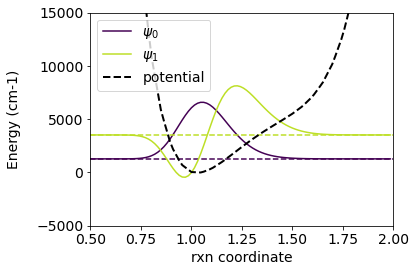

In [65]:
clhocl_rOH_anDVR.plot_wfns(states=[0,1], on_pot=True, y_range=[-5000,15000], scale=20000, save_file="clhocl_rOH_dvr_wfns.pdf")

## Cl HOD

In [71]:
clhod_rOH_s = gt.GLogInterpreter("rOH_s_oop_0/clhod/clhod_rOH_s_05-20.log")

In [72]:
clhod_rOH_s.Energy

array([-535.34883, -535.60772, -535.78683, -535.91049, -535.99517,
       -536.05223, -536.08961, -536.11294, -536.12628, -536.13257,
       -536.13396, -536.13203, -536.12797, -536.12265, -536.11675,
       -536.11073, -536.10494, -536.0996 , -536.09483, -536.09067,
       -536.08711, -536.08405, -536.08136, -536.0788 , -536.07606,
       -536.07269, -536.06813, -536.06162, -536.05219, -536.03864,
       -536.01943])

In [ ]:
clhod_grid = dvr.Grid(domain=uts.Constants.convert([0.5,2], to_AU=True, unit="angstroms" ), num_points=100).grid

In [ ]:
uts.Constants.convert([0.5,2], to_AU=True, unit="angstroms" )

In [ ]:
clhod_f_linear = interpolate.interp1d(np.linspace(uts.Constants.convert(0.5, to_AU=True, unit="angstroms" ),
                                            uts.Constants.convert(2, to_AU=True, unit="angstroms" ), 31),
                                clhod_rOH_s.Energy,
                                kind='linear', fill_value='extrapolate',
                                bounds_error=False)  # linear spline

In [ ]:
clhod_pot_array = clhod_f_linear(OH_grid)
clhod_pot_array = clhod_pot_array - clhod_pot_array.min()
clhod_pot_matrix = np.diag(clhod_pot_array)

In [ ]:
clhod_kinetic = dvr_arrays.CM_1D_kin_mat(grid=clhod_grid,
                                   interval='-infty_to_infty',
                                   mass= uts.Constants.reduced_mass("O-H"))

In [ ]:
clhod_rOH_dvr = dvr.DVR_1D(grid=clhod_grid, kinetic_matrix=clhod_kinetic.matrix, potential_matrix=clhod_pot_matrix, filename="clhod_rOH_dvr")

In [ ]:
clhod_rOH_dvr.run()

In [4]:
clhod_rOH_anDVR = dvr.AnalyzeDVR("clhod_rOH_dvr", grid_unit='angstroms')

In [ ]:
clhod_rOH_anDVR.plot_wfns(states=[0,1], on_pot=True, y_range=[-5000,15000], scale=20000, save_file="clhod_rOH_dvr_wfns.pdf")

## HOCl

In [46]:
hocl_rOH_s = gt.GLogInterpreter("rOH_s_oop_0/hocl/hocl_rOH_s.log")

In [47]:
hocl_rOH_s.Energy

array([-535.03191, -535.1551 , -535.23919, -535.29551, -535.332  ,
       -535.35426, -535.3663 , -535.37102, -535.37051, -535.36632,
       -535.35956, -535.35107, -535.34147, -535.33122, -535.32066,
       -535.31004, -535.29956, -535.28934, -535.27949, -535.27006,
       -535.2611 , -535.25264, -535.2447 , -535.23727, -535.23037,
       -535.22398, -535.21809, -535.2127 , -535.20777])

In [48]:
hocl_grid = dvr.Grid(domain=uts.Constants.convert([0.6,2], to_AU=True, unit="angstroms" ), num_points=100).grid

In [49]:
uts.Constants.convert([0.6,2], to_AU=True, unit="angstroms" )

array([1.13383613, 3.77945376])

In [51]:
hocl_f_linear = interpolate.interp1d(np.linspace(uts.Constants.convert(0.6, to_AU=True, unit="angstroms" ),
                                            uts.Constants.convert(2, to_AU=True, unit="angstroms" ), 29),
                                hocl_rOH_s.Energy,
                                kind='linear', fill_value='extrapolate',
                                bounds_error=False)  # linear spline

In [54]:
hocl_pot_array = hocl_f_linear(hocl_grid)
hocl_pot_array = hocl_pot_array - hocl_pot_array.min()
hocl_pot_matrix = np.diag(hocl_pot_array)

In [55]:
hocl_kinetic = dvr_arrays.CM_1D_kin_mat(grid=hocl_grid,
                                   interval='-infty_to_infty',
                                   mass= uts.Constants.reduced_mass("O-H"))

In [56]:
hocl_rOH_dvr = dvr.DVR_1D(grid=hocl_grid, kinetic_matrix=hocl_kinetic.matrix, potential_matrix=hocl_pot_matrix, filename="hocl_rOH_dvr")

In [57]:
hocl_rOH_dvr.run()

In [58]:
hocl_rOH_anDVR = dvr.AnalyzeDVR("hocl_rOH_dvr", grid_unit='angstroms')

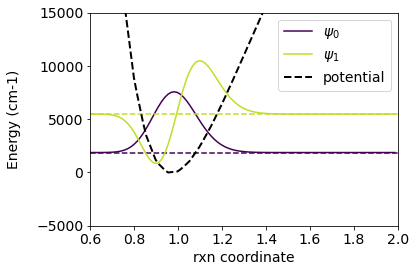

In [59]:
hocl_rOH_anDVR.plot_wfns(states=[0,1], on_pot=True, y_range=[-5000,15000], scale=20000, save_file="hocl_rOH_dvr_wfns.pdf")

## HOD

In [62]:
hod_rOH_s = gt.GLogInterpreter("rOH_s_oop_0/hod/hod_rOH_s.log")

hod_grid = dvr.Grid(domain=uts.Constants.convert([0.6,2], to_AU=True, unit="angstroms" ), num_points=100).grid

uts.Constants.convert([0.6,2], to_AU=True, unit="angstroms" )

hod_f_linear = interpolate.interp1d(np.linspace(uts.Constants.convert(0.6, to_AU=True, unit="angstroms" ),
                                            uts.Constants.convert(2, to_AU=True, unit="angstroms" ), 29),
                                hod_rOH_s.Energy,
                                kind='linear', fill_value='extrapolate',
                                bounds_error=False)  # linear spline

hod_pot_array = hod_f_linear(hod_grid)
hod_pot_array = hod_pot_array - hod_pot_array.min()
hod_pot_matrix = np.diag(hod_pot_array)

hod_kinetic = dvr_arrays.CM_1D_kin_mat(grid=hod_grid,
                                   interval='-infty_to_infty',
                                   mass= uts.Constants.reduced_mass("O-D"))

hod_rOH_dvr = dvr.DVR_1D(grid=hod_grid, kinetic_matrix=hod_kinetic.matrix, potential_matrix=hod_pot_matrix, filename="hod_rOH_dvr")

hod_rOH_dvr.run()

hod_rOH_anDVR = dvr.AnalyzeDVR("hod_rOH_dvr", grid_unit='angstroms')

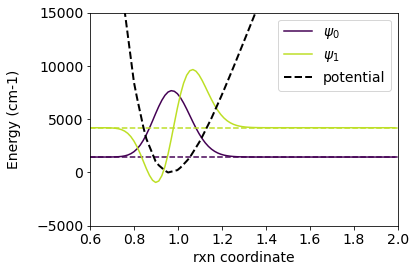

In [63]:
hod_rOH_anDVR.plot_wfns(states=[0,1], on_pot=True, y_range=[-5000,15000], scale=20000, save_file="hod_rOH_dvr_wfns.pdf")

## Save results to Excel

In [3]:
clhod_rOH_anDVR.save_to_excel(num_wfns=10, save_file="clhod_rOH_DVR.xlsx")

In [ ]:
clhocl_rOH_anDVR.save_to_excel(num_wfns=10, save_file="clhocl_rOH_DVR.xlsx")

## Combining these into a nice plot...

(-5000.0, 15000.0)

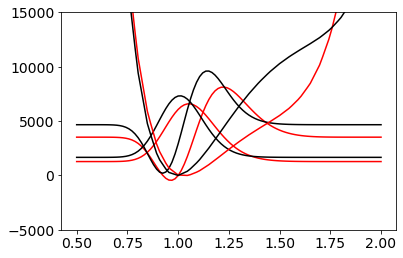

In [90]:
fig = plt.figure()
ax = plt.axes()

scale=20000
plt.plot(clhocl_rOH_anDVR.results['grid'],
        (clhocl_rOH_anDVR.results['wfns'][:,0]*scale) + clhocl_rOH_anDVR.results['energies'][0],
        color='red')
plt.plot(clhocl_rOH_anDVR.results['grid'],
        (clhocl_rOH_anDVR.results['wfns'][:,1]*scale) + clhocl_rOH_anDVR.results['energies'][1],
        color='red')
plt.plot(clhod_rOH_anDVR.results['grid'],
         (clhod_rOH_anDVR.results['wfns'][:,0]*scale) + clhod_rOH_anDVR.results['energies'][0],
        color='black')
plt.plot(clhod_rOH_anDVR.results['grid'],
         (clhod_rOH_anDVR.results['wfns'][:,1]*scale) + clhod_rOH_anDVR.results['energies'][1],
        color='black')

plt.plot(clhocl_rOH_anDVR.results['grid'],
        clhocl_rOH_anDVR.results['potential'],
        color='red')
plt.plot(clhod_rOH_anDVR.results['grid'],
        clhod_rOH_anDVR.results['potential'],
        color='black')

ax.set_ylim(-5000,15000)



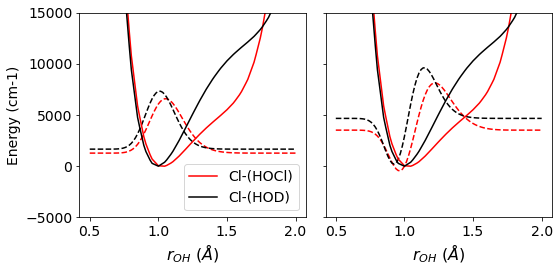

In [102]:
fig, axs = plt.subplots(1, 2, sharey=True)

scale=20000
axs[0].plot(clhocl_rOH_anDVR.results['grid'],
        (clhocl_rOH_anDVR.results['wfns'][:,0]*scale) + clhocl_rOH_anDVR.results['energies'][0],
        color='red',
        linestyle='--')
axs[1].plot(clhocl_rOH_anDVR.results['grid'],
        (clhocl_rOH_anDVR.results['wfns'][:,1]*scale) + clhocl_rOH_anDVR.results['energies'][1],
        color='red',
        linestyle='--')
axs[0].plot(clhod_rOH_anDVR.results['grid'],
         (clhod_rOH_anDVR.results['wfns'][:,0]*scale) + clhod_rOH_anDVR.results['energies'][0],
        color='black',
        linestyle='--')
axs[1].plot(clhod_rOH_anDVR.results['grid'],
         (clhod_rOH_anDVR.results['wfns'][:,1]*scale) + clhod_rOH_anDVR.results['energies'][1],
        color='black',
        linestyle='--')

axs[0].plot(clhocl_rOH_anDVR.results['grid'],
        clhocl_rOH_anDVR.results['potential'],
        color='red', label="Cl-(HOCl)")
axs[0].plot(clhod_rOH_anDVR.results['grid'],
        clhod_rOH_anDVR.results['potential'],
        color='black', label="Cl-(HOD)")
axs[1].plot(clhocl_rOH_anDVR.results['grid'],
        clhocl_rOH_anDVR.results['potential'],
        color='red')
axs[1].plot(clhod_rOH_anDVR.results['grid'],
        clhod_rOH_anDVR.results['potential'],
        color='black')

axs[0].legend(loc='best')
axs[0].set_ylim(-5000,15000)
axs[1].set_ylim(-5000,15000)

axs[0].set_ylabel("Energy (cm-1)")
axs[0].set_xlabel(r'$r_{OH}$ ($\AA$)', fontsize=16)
axs[1].set_xlabel(r'$r_{OH}$ ($\AA$)', fontsize=16)

fig.subplots_adjust(wspace = 0, hspace = 0)
fig.set_size_inches(w=8,h=4)
plt.tight_layout()
plt.savefig('clhod_clhocl_rOH_DVR_2.pdf')

## calculating $r_{eq}$ and $r_0$

- $r_{eq}$ is the bottom of the potential
- $r_0$ is the average (expectation) value of r
    - $\int_{-\infty}^{\infty} r|\psi(r)|^2 dr$
    - or in discrete space...
    - $\sum r|\psi(r)|^2 \Delta r$

In [42]:
def exp_val(dvr,state=0):
    ev = 0
    for r in range(len(dvr['grid'])):
        ev = ev + dvr['grid'][r]*dvr['wfns'][r,state]**2
    return ev

### ClHOCl

In [13]:
clhocl_req = clhocl_rOH_anDVR.results['grid'][np.argmin(clhocl_rOH_anDVR.results['potential'])]

In [43]:
clhocl_r0 = exp_val(clhocl_rOH_anDVR.results, 0)

In [44]:
clhocl_r0

1.065360548478518

### ClHOD

In [14]:
clhod_req = clhod_rOH_anDVR.results['grid'][np.argmin(clhod_rOH_anDVR.results['potential'])]

In [45]:
clhod_r0 = exp_val(clhod_rOH_anDVR.results, 0)
print(clhod_r0)

1.0173580327632508


### HOCl

In [70]:
hocl_req = hocl_rOH_anDVR.results['grid'][np.argmin(hocl_rOH_anDVR.results['potential'])]
print(hocl_req)

0.9535353535353535


In [71]:
hocl_r0 = exp_val(hocl_rOH_anDVR.results, 0)
print(hocl_r0)

0.9865946743286979


### HOD

In [69]:
hod_req = hod_rOH_anDVR.results['grid'][np.argmin(hod_rOH_anDVR.results['potential'])]
print(hod_req)

0.9535353535353535


In [73]:
hod_r0 = exp_val(hod_rOH_anDVR.results, 0)
print(hod_r0)

0.9742255543617662
